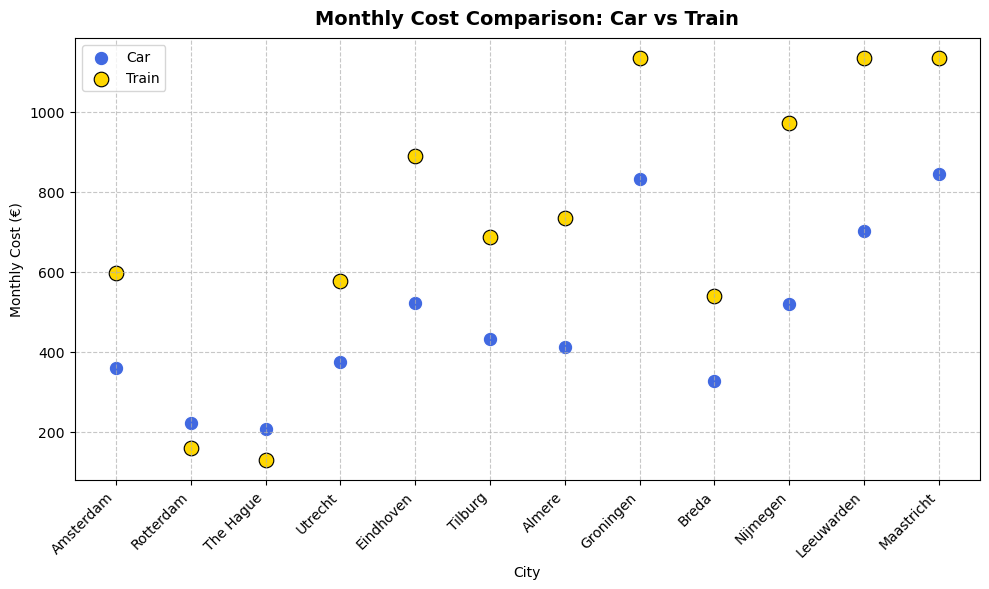

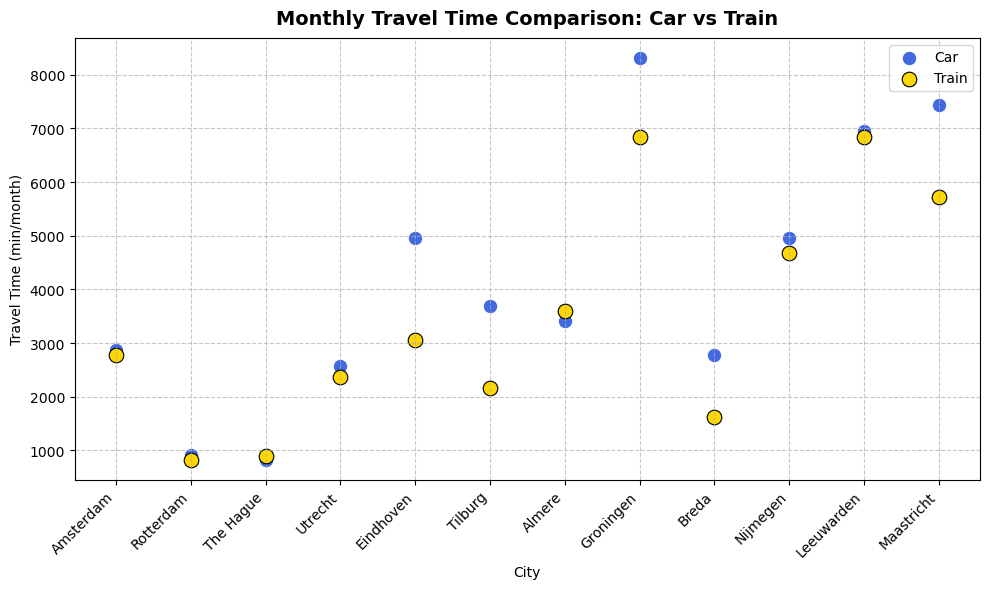

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install adjustText
from adjustText import adjust_text

# --- Load data ---
car = pd.read_csv("../processed_data/CarCostTime_tidy.csv")  # City,CarCost_EUR_per_month,CarTime_min_per_month
train = pd.read_csv("../processed_data/train_monthly_summary.csv")  # city,time_per_month_min,cost_per_month_eur

# --- Standardize column names ---
car.columns = ["City_car", "CarCost_EUR_per_month", "CarTime_min_per_month"]
train.columns = ["City_train", "TrainTime_min_per_month", "TrainCost_EUR_per_month"]

# --- Create a normalized city key to join on ---
def normalize_city(s: str) -> str:
    s = s.strip()
    # map long station names to short city names
    mapping = {
        "Amsterdam Centraal": "Amsterdam",
        "Rotterdam Centraal": "Rotterdam",
        "Den Haag Centraal": "The Hague",
        "Utrecht Centraal": "Utrecht",
        "Eindhoven Centraal": "Eindhoven",
        "Tilburg Centraal": "Tilburg",
        "Almere Centrum": "Almere",
        "Groningen Centraal": "Groningen",
        "Breda Centraal": "Breda",
        "Nijmegen Centraal": "Nijmegen",
        "Leeuwarden Centraal": "Leeuwarden",
        "Maastricht Centraal": "Maastricht",
    }
    return mapping.get(s, s)

car["City"] = car["City_car"].apply(normalize_city)
train["City"] = train["City_train"].str.strip()

# --- Ensure numeric types (in case they were read as strings) ---
for col in ["CarCost_EUR_per_month", "CarTime_min_per_month"]:
    car[col] = pd.to_numeric(car[col], errors="coerce")
for col in ["TrainTime_min_per_month", "TrainCost_EUR_per_month"]:
    train[col] = pd.to_numeric(train[col], errors="coerce")

# --- Merge ---
df = pd.merge(car[["City", "CarCost_EUR_per_month", "CarTime_min_per_month"]],
              train[["City", "TrainTime_min_per_month", "TrainCost_EUR_per_month"]],
              on="City", how="inner")

# Optional: check what matched
# print(df[["City"]])

# ========= Plot 1: Cost comparison (Car vs Train) =========
plt.figure(figsize=(10, 6))
sns.scatterplot(x="City", y="CarCost_EUR_per_month", data=df, s=110, color="royalblue", label="Car")
sns.scatterplot(x="City", y="TrainCost_EUR_per_month", data=df, s=110, color="gold", edgecolor="black", label="Train")
plt.title("Monthly Cost Comparison: Car vs Train", fontsize=14, weight="bold", pad=10)
plt.ylabel("Monthly Cost (€)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# ========= Plot 2: Time comparison (Car vs Train) =========
plt.figure(figsize=(10, 6))
sns.scatterplot(x="City", y="CarTime_min_per_month", data=df, s=110, color="royalblue", label="Car")
sns.scatterplot(x="City", y="TrainTime_min_per_month", data=df, s=110, color="gold", edgecolor="black", label="Train")
plt.title("Monthly Travel Time Comparison: Car vs Train", fontsize=14, weight="bold", pad=10)
plt.ylabel("Travel Time (min/month)")
plt.xlabel("City")
plt.xticks(rotation=45, ha="right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()



📍 Intersection point at ≈ 930 min/month, €220


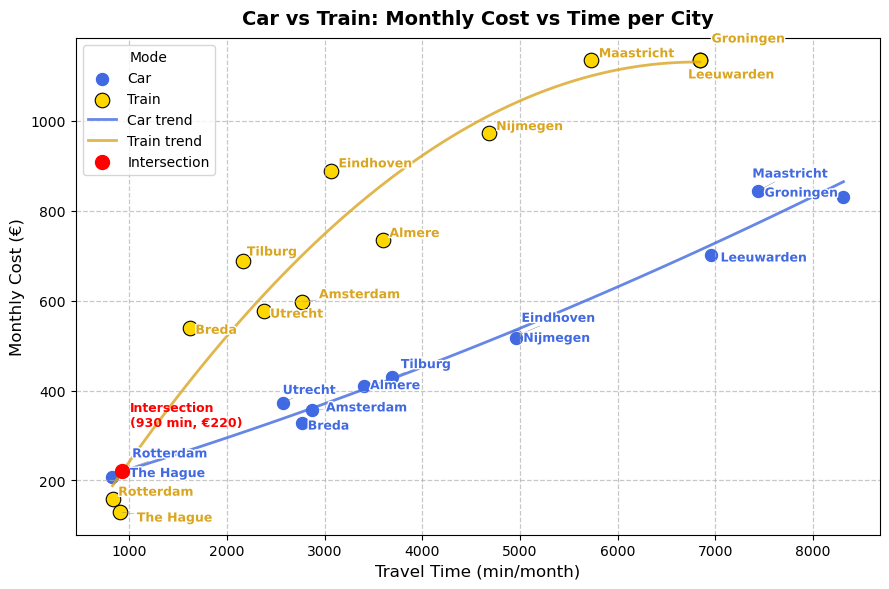

In [2]:
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

fig, ax = plt.subplots(figsize=(9, 6))

# --- Scatter points ---
ax.scatter(
    df["CarTime_min_per_month"], df["CarCost_EUR_per_month"],
    s=110, color="royalblue", edgecolors="white", linewidth=0.8, label="Car"
)
ax.scatter(
    df["TrainTime_min_per_month"], df["TrainCost_EUR_per_month"],
    s=110, color="gold", edgecolors="black", linewidth=0.8, label="Train"
)

p_car = np.poly1d(np.polyfit(df["CarTime_min_per_month"], df["CarCost_EUR_per_month"], 2))
x_car_line = np.linspace(df["CarTime_min_per_month"].min(), df["CarTime_min_per_month"].max(), 100)
ax.plot(x_car_line, p_car(x_car_line), color="royalblue", linewidth=2, alpha=0.8, label="Car trend")

# Train trend (polynomial curve)
p_train = np.poly1d(np.polyfit(df["TrainTime_min_per_month"], df["TrainCost_EUR_per_month"], 2))
x_train_line = np.linspace(df["TrainTime_min_per_month"].min(), df["TrainTime_min_per_month"].max(), 100)
ax.plot(x_train_line, p_train(x_train_line), color="goldenrod", linewidth=2, alpha=0.8, label="Train trend")
# ----------------------------------------------------------------
# 🔹 Find intersection point of the two curves
# ----------------------------------------------------------------
# The intersection happens when p_car(x) = p_train(x)
coeff_diff = np.polysub(p_car, p_train)  # subtract polynomials
roots = np.roots(coeff_diff)              # find where they cross

# Pick only real intersections within your time range
x_intersects = [x for x in roots if np.isreal(x) and 
                min(x_car_line.min(), x_train_line.min()) < x < max(x_car_line.max(), x_train_line.max())]

if x_intersects:
    x_int = np.real(x_intersects[0])
    y_int = p_car(x_int)
    ax.scatter(x_int, y_int, color="red", s=100, zorder=5, label="Intersection")
    ax.text(x_int + 80, y_int + 100,
            f"Intersection\n({x_int:.0f} min, €{y_int:.0f})",
            fontsize=9, color="red", weight="bold")
    print(f"📍 Intersection point at ≈ {x_int:.0f} min/month, €{y_int:.0f}")
else:
    print("No intersection found within the data range.")
# ----------------------------------------------------------------

# --- Collect labels for adjustment ---
texts = []
for _, r in df.iterrows():
    city = str(r["City"])

    # --- Car label (normal) ---
    texts.append(
        ax.text(
            r["CarTime_min_per_month"], r["CarCost_EUR_per_month"], city,
            fontsize=9, color="royalblue", weight="bold",
            path_effects=[pe.withStroke(linewidth=2, foreground="white")]
        )
    )

    # --- Train label (offset only for Groningen / Leeuwarden) ---
    tx = r["TrainTime_min_per_month"]
    ty = r["TrainCost_EUR_per_month"]

    lower = city.lower()
    if lower.startswith("groningen"):
        tx += 120   # move right
        ty += 40    # move up
        fixed_train = True
    elif lower.startswith("leeuwarden"):
        tx -= 120   # move left
        ty -= 40    # move down
        fixed_train = True
    else:
        fixed_train = False

    train_text = ax.text(
        tx, ty, city,
        fontsize=9, color="goldenrod", weight="bold",
        path_effects=[pe.withStroke(linewidth=2, foreground="white")]
    )

    # Only let adjust_text move labels that are NOT manually fixed
    if not fixed_train:
        texts.append(train_text)

# --- Automatically adjust text to avoid overlap ---
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="gray", lw=0.3), ax=ax)

# --- Styling ---
ax.set_title("Car vs Train: Monthly Cost vs Time per City", fontsize=14, weight="bold", pad=10)
ax.set_xlabel("Travel Time (min/month)", fontsize=12)
ax.set_ylabel("Monthly Cost (€)", fontsize=12)
ax.grid(True, linestyle="--", linewidth=0.9, alpha=0.7)
ax.legend(title="Mode", fontsize=10)




fig.tight_layout()
plt.show()




This graph compares monthly travel cost (€) and time (minutes/month) for cars (blue) and trains (yellow) across cities. The trends show that train travel is cheaper for shorter commutes, but costs rise steeply with longer distances, while car costs increase more gradually. The two modes intersect around 930 minutes/month and €220, marking the break-even point: below it, trains are more economical; beyond it, cars become cheaper overall. This suggests trains are ideal for short urban trips, whereas cars offer better cost efficiency for longer commutes.

,Station,TrajectVrij_plus_Swapfiets_EUR_per_month,CarCost_EUR_per_month,Result,Monthly_Savings_EUR
0,Amsterdam Centraal,388.7,357.77,Car,-30.93
1,Rotterdam Centraal,112.5,221.94,Train,109.44
2,Den Haag Centraal,88.6,207.12,Train,118.52
3,Utrecht Centraal,382.1,372.74,Car,-9.36
4,Eindhoven Centraal,393.6,521.18,Train,127.58
5,Tilburg Centraal,393.6,430.11,Train,36.51
6,Almere Centrum,393.6,410.90,Train,17.30
7,Groningen Centraal,393.6,831.18,Train,437.58
8,Breda Centraal,357.2,326.87,Car,-30.33
9,Nijmegen Centraal,393.6,517.73,Train,124.13


C:\Users\sapia\AppData\Local\Temp\ipykernel_16704\1923141490.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(merged["Station"], rotation=45, ha="right")


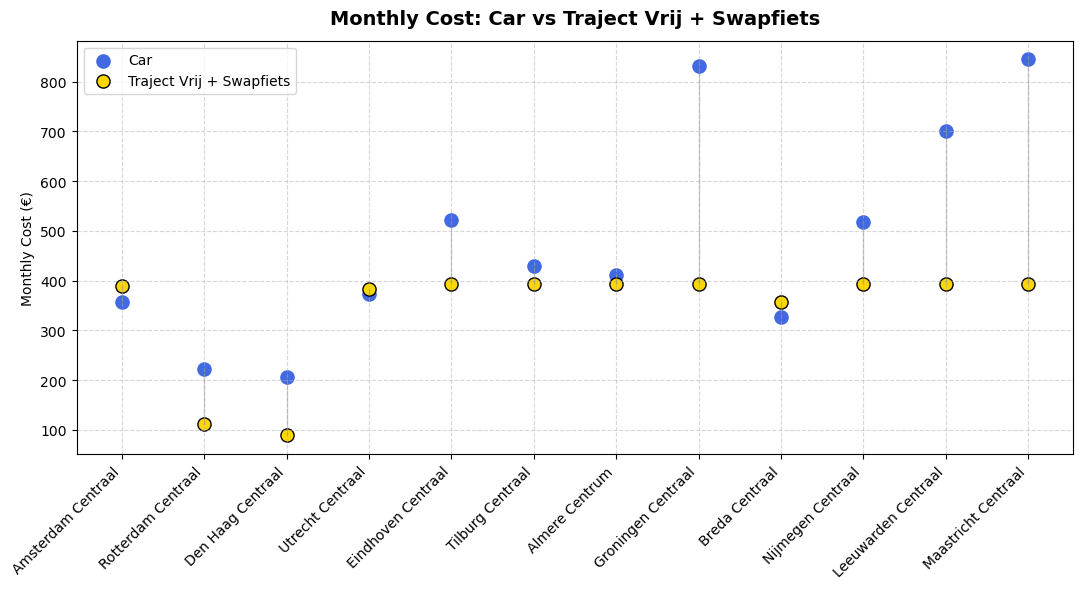

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Fixed order using station names
STATIONS = [
    "Amsterdam Centraal","Rotterdam Centraal","Den Haag Centraal","Utrecht Centraal",
    "Eindhoven Centraal","Tilburg Centraal","Almere Centrum","Groningen Centraal",
    "Breda Centraal","Nijmegen Centraal","Leeuwarden Centraal","Maastricht Centraal"
]

# Traject Vrij + Swapfiets (aligned to STATIONS order)
sub_df = pd.DataFrame({
    "Station": STATIONS,
    "TrajectVrij_plus_Swapfiets_EUR_per_month": [
        388.70, 112.50, 88.60, 382.10,
        393.60, 393.60, 393.60, 393.60,
        357.20, 393.60, 393.60, 393.60
    ],
})

# Load car costs (expects matching station names)
car = pd.read_csv(Path("../processed_data") / "CarCostTime_tidy.csv")
car = (
    car.rename(columns=str.lower)[["city", "carcost_eur_per_month"]]
       .rename(columns={"city": "Station", "carcost_eur_per_month": "CarCost_EUR_per_month"})
)

# Merge + calcs + enforce order
merged = (
    sub_df.merge(car, on="Station", how="inner", validate="one_to_one")
          .assign(
              Result=lambda d: np.where(
                  d["TrajectVrij_plus_Swapfiets_EUR_per_month"] <= d["CarCost_EUR_per_month"],
                  "Train", "Car"
              ),
              Monthly_Savings_EUR=lambda d: (
                  d["CarCost_EUR_per_month"] - d["TrajectVrij_plus_Swapfiets_EUR_per_month"]
              ).round(2)
          )
          .set_index("Station").loc[STATIONS].reset_index()
)

display(merged)

# Plot
fig, ax = plt.subplots(figsize=(11, 6))
ax.scatter(merged["Station"], merged["CarCost_EUR_per_month"], s=90, color="royalblue", label="Car")
ax.scatter(merged["Station"], merged["TrajectVrij_plus_Swapfiets_EUR_per_month"], s=90, color="gold", edgecolors="black", label="Traject Vrij + Swapfiets")
for x, y1, y2 in zip(merged["Station"], merged["CarCost_EUR_per_month"], merged["TrajectVrij_plus_Swapfiets_EUR_per_month"]):
    ax.plot([x, x], [y1, y2], color="gray", alpha=0.35, linewidth=1)

ax.set_title("Monthly Cost: Car vs Traject Vrij + Swapfiets", fontsize=14, weight="bold", pad=12)
ax.set_ylabel("Monthly Cost (€)")
ax.set_xticklabels(merged["Station"], rotation=45, ha="right")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
fig.tight_layout()
plt.show()


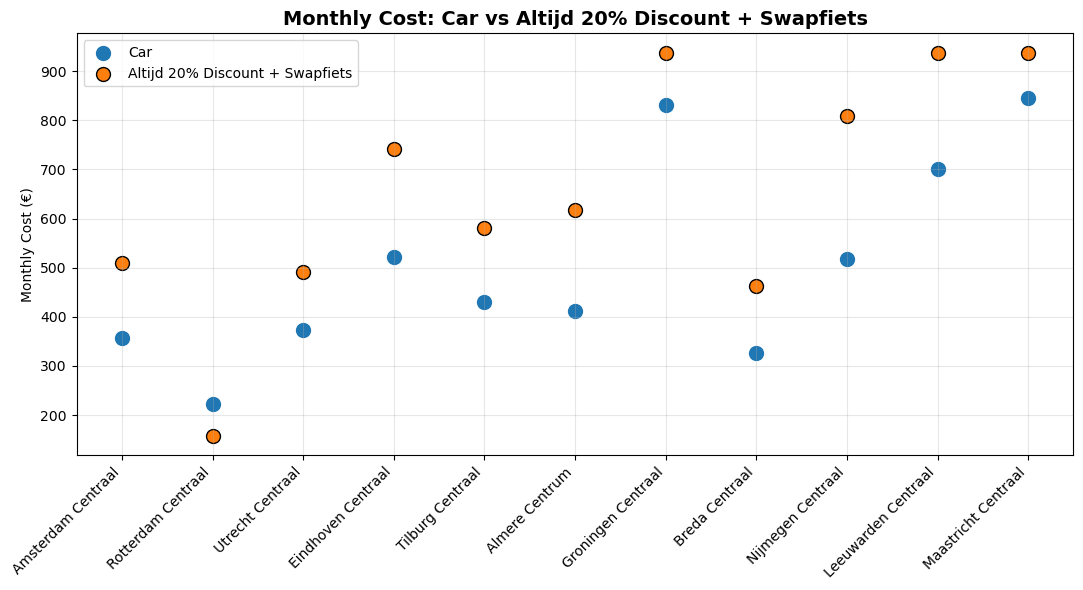

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# ---------- helpers ----------
def normalize_cols(df):
    df.columns = df.columns.str.replace('\ufeff','', regex=False).str.strip().str.lower()
    return df

def clean_city(s):
    if pd.isna(s): return s
    s = str(s).strip().lower()
    # remove common suffixes seen in your files/plots
    s = re.sub(r'\b(centraal|centrum|central|station)\b', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def to_num(series):
    return pd.to_numeric(
        series.astype(str)
              .str.replace('€','', regex=False)
              .str.replace(' ','', regex=False)
              .str.replace(',', '.', regex=False),
        errors='coerce'
    )

# ---------- load ----------
car = pd.read_csv("../processed_data/CarCostTime_tidy.csv")
train = pd.read_csv("../processed_data/altijd_20_peak_discount.csv")

# ---------- normalize ----------
car = normalize_cols(car)
train = normalize_cols(train)

# find/rename columns
if "carcost_eur_per_month" in car.columns:
    car = car.rename(columns={"carcost_eur_per_month": "cost_per_month_eur"})
elif "cost_per_month_eur" not in car.columns:
    raise KeyError(f"Car file: can't find monthly cost column. Columns: {list(car.columns)}")

# train column (from your CSV screenshot)
if "cost_per_month_eur_altijd_peak20" not in train.columns:
    # try a couple of common variants
    for alt in ["cost_per_month_eur_altijd20","cost_per_month_eur_altijd_20","cost_per_month_eur_altijd"]:
        if alt in train.columns:
            train = train.rename(columns={alt: "cost_per_month_eur_altijd_peak20"})
            break
if "cost_per_month_eur_altijd_peak20" not in train.columns:
    raise KeyError(f"Train file: can't find 'cost_per_month_eur_altijd_peak20'. Columns: {list(train.columns)}")

# guess city column if not literally "city"
def pick_city(df):
    for c in ["city","city_name","destination_city","destination","station","station_name"]:
        if c in df.columns:
            return c
    raise KeyError(f"No city-like column. Columns: {list(df.columns)}")

car_city = pick_city(car)
train_city = pick_city(train)
car = car.rename(columns={car_city: "city"})
train = train.rename(columns={train_city: "city"})

# clean city keys
car["city_key"] = car["city"].map(clean_city)
train["city_key"] = train["city"].map(clean_city)

# costs to numeric
car["cost_per_month_eur"] = to_num(car["cost_per_month_eur"])
train["cost_per_month_eur_altijd_peak20"] = to_num(train["cost_per_month_eur_altijd_peak20"])

# ---------- merge ----------
merged = pd.merge(
    car[["city","city_key","cost_per_month_eur"]],
    train[["city","city_key","cost_per_month_eur_altijd_peak20"]],
    on="city_key",
    how="inner",
    suffixes=("_car","_train")
)

# If nothing merged, show you what's mismatching
if merged.empty:
    set_car = set(car["city_key"].dropna().unique())
    set_train = set(train["city_key"].dropna().unique())
    only_car = sorted(set_car - set_train)
    only_train = sorted(set_train - set_car)
   

 

# ---------- plot ----------
if not merged.empty:
    # Nicely formatted labels from the car city names (could also choose _train)
    labels = merged["city_car"].str.title()

    plt.figure(figsize=(11,6))
    plt.scatter(labels, merged["cost_per_month_eur"], s=100, label="Car")
    plt.scatter(labels, merged["cost_per_month_eur_altijd_peak20"], s=100, edgecolor="black",
                label="Altijd 20% Discount + Swapfiets")

    plt.title("Monthly Cost: Car vs Altijd 20% Discount + Swapfiets", fontsize=14, fontweight="bold")
    plt.ylabel("Monthly Cost (€)")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

